# Klasifikasi Tumor Otak Menggunakan Transfer Learning dengan VGG16 di TensorFlow

## **Instalasi dan Import Library**

*Menginstal library TensorFlow dan scikit-learn yang dibutuhkan untuk pembuatan model deep learning dan evaluasi klasifikasi*

In [1]:
!pip install tensorflow scikit-learn

In [53]:
# Standard Library
import os
import shutil
import random
import zipfile

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image
import cv2

# Machine Learning & Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Google Colab
from google.colab import files
from google.colab import drive

## **Data Understanding**

*Menghubungkan Google Drive dengan Google Colab agar file dapat diakses secara langsung. File dataset berbentuk ZIP kemudian diekstrak ke direktori yang telah ditentukan di lingkungan Colab. Setelah proses ekstraksi, kode akan menelusuri dan mencetak seluruh path file yang ada di folder hasil ekstrak tersebut.*

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_file_path = '/content/drive/MyDrive/tumor_otak_dataset.zip'

extract_path = '/content/brain_tumor/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memeriksa Isi Dataset
for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))

/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(8).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(7).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(78).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(31).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(97).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(35).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(69).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(94).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(2).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(21).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/pituitary_tumor/image(20).jpg
/content/brain_tumor/tumor_otak_dat

## **Data Preparation**

*Mendefinisikan lokasi folder dataset training dan testing dari dua sumber sebagai langkah awal persiapan data sebelum pengolahan lebih lanjut.*

In [5]:
dataset_paths = [
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Training',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Training',
]

In [6]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)

for path in dataset_paths:
    for cls in classes:
        src_dir = os.path.join(path, cls)
        dst_dir = os.path.join(combined_dir, cls)
        if os.path.exists(src_dir):
            for fname in os.listdir(src_dir):
                src_file = os.path.join(src_dir, fname)
                dst_file = os.path.join(dst_dir, fname)
                shutil.copy2(src_file, dst_file)

## **Exploratory Data Analysis (EDA)**

*Menampilkan 12 gambar tumor otak secara acak dari dataset gabungan, beserta label kelasnya, untuk memberikan gambaran visual awal data sebelum proses pelatihan model.*

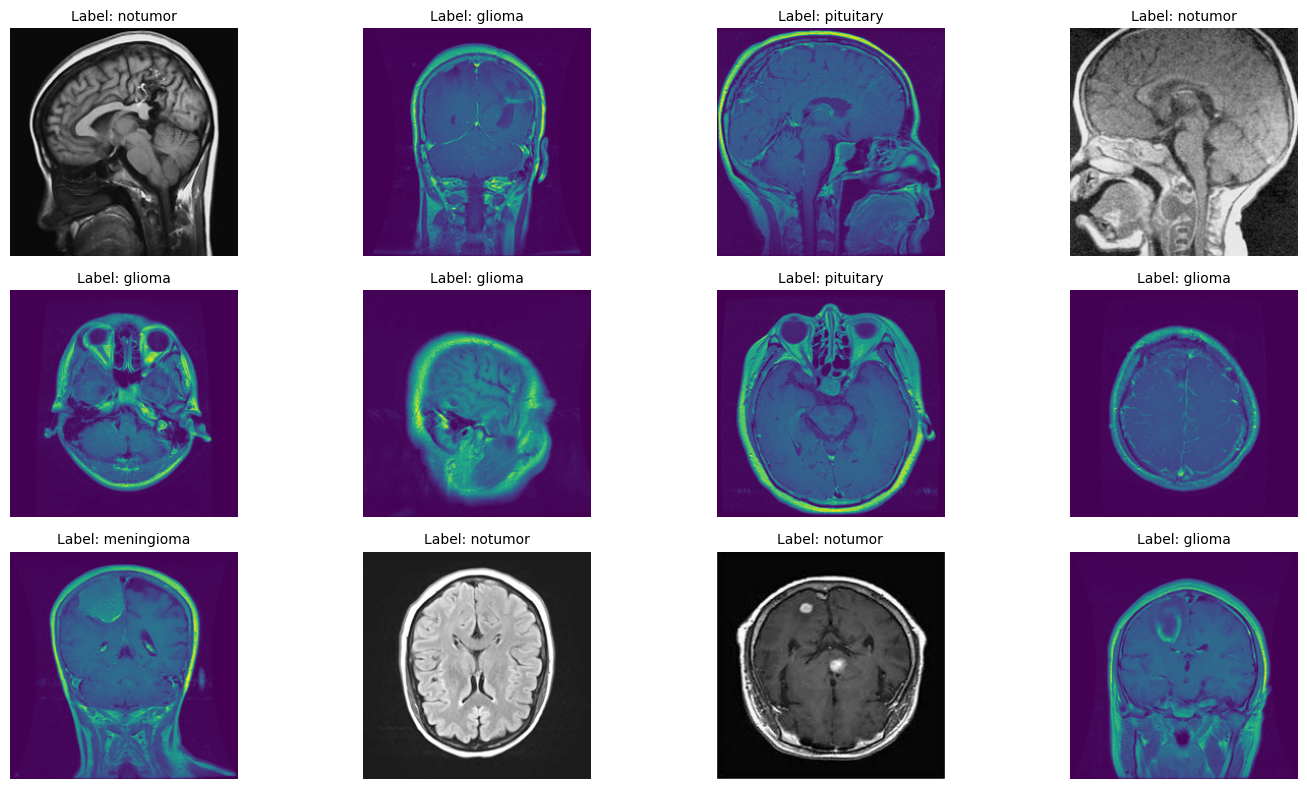

In [7]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

combined_paths = []
combined_labels = []

for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        combined_paths.append(os.path.join(path, name))
        combined_labels.append(os.path.basename(path))

random_choice = random.sample(range(len(combined_paths)), 12)

fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_choice):
    img_path = combined_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {combined_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

*Menampilkan grafik distribusi jumlah gambar untuk setiap kelas tumor otak di folder gabungan, untuk membantu melihat keseimbangan data sebelum pemodelan.*

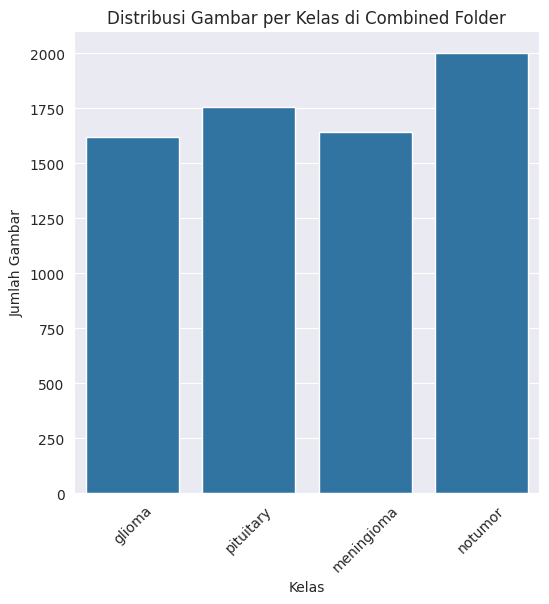

In [8]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="label")
plt.title("Distribusi Gambar per Kelas di Combined Folder")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

*Menghitung dan menampilkan jumlah gambar untuk setiap kelas tumor di folder gabungan, untuk membantu melihat distribusi data secara keseluruhan.*

In [9]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

class_counts = distribution_df['label'].value_counts()
print("Jumlah data per kelas di folder Combined:")
print(class_counts)

Jumlah data per kelas di folder Combined:
label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


## **Data Preparation**

*Membagi data gambar tumor otak menjadi tiga bagian menjadi train (70%), val (20%), dan test (10%) untuk setiap kelas tumor. Setelah pembagian, menampilkan jumlah gambar di masing-masing bagian untuk memastikan distribusi data sudah benar.*

In [10]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

split_dataset_dir = "/content/brain_tumor/split"
train_dir = os.path.join(split_dataset_dir, "train")
val_dir = os.path.join(split_dataset_dir, "val")
test_dir = os.path.join(split_dataset_dir, "test")

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

val_ratio = 0.2
test_ratio = 0.1

for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    train_val_files, test_files = train_test_split(files, test_size=test_ratio, random_state=42)

    val_size_adjusted = val_ratio / (1 - test_ratio)
    train_files, val_files = train_test_split(train_val_files, test_size=val_size_adjusted, random_state=42)

    def salin(files, destination_dir):
        os.makedirs(os.path.join(destination_dir, class_name), exist_ok=True)
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(destination_dir, class_name, file)
            shutil.copy2(src, dst)

    salin(train_files, train_dir)
    salin(val_files, val_dir)
    salin(test_files, test_dir)

print("Dataset berhasil dibagi: 70% train, 20% validation, 10% test.")

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dataset_dir, split)
    print(f"\n{split.upper()} SET:")
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        num_images = len(os.listdir(class_path))
        print(f"- {class_name}: {num_images} images")

Dataset berhasil dibagi: 70% train, 20% validation, 10% test.

TRAIN SET:
- glioma: 1134 images
- pituitary: 1229 images
- meningioma: 1151 images
- notumor: 1400 images

VAL SET:
- glioma: 324 images
- pituitary: 352 images
- meningioma: 329 images
- notumor: 400 images

TEST SET:
- glioma: 163 images
- pituitary: 176 images
- meningioma: 165 images
- notumor: 200 images


**Visualisasi Distribusi Data per Kelas pada Set Train, Validation, dan Test**

*Menghitung jumlah gambar untuk setiap kelas di masing-masing dataset split: train, validation, dan test. Hasilnya, divisualisasikan menggunakan stacked bar chart untuk memudahkan pemahaman distribusi data per kelas di setiap split.*


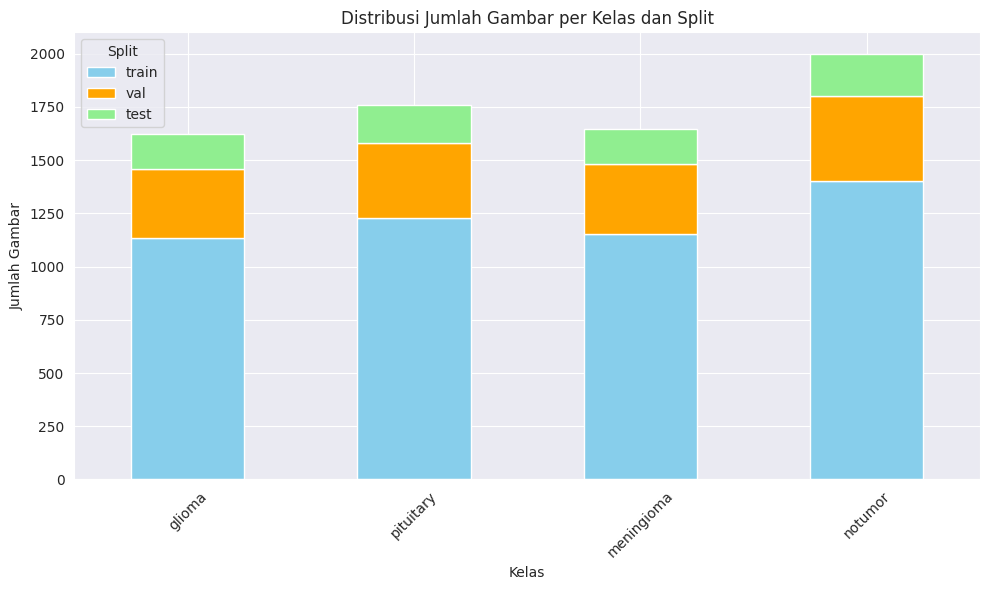

In [11]:
split_counts = {'train': [], 'val': [], 'test': []}
classes = os.listdir(train_dir)

for split in ['train', 'val', 'test']:
    for class_name in classes:
        path = os.path.join(split_dataset_dir, split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        split_counts[split].append(count)

df = pd.DataFrame(split_counts, index=classes)

df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribusi Jumlah Gambar per Kelas dan Split')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

*Gambar diolah dengan augmentasi dan normalisasi, lalu dimuat dari folder, diubah ukuran, dan dikategorikan supaya siap untuk pelatihan dan validasi model.*

In [24]:
# === ImageDataGenerator === #
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# === Load Dataset === #
train_data = train_datagen.flow_from_directory(
    '/content/brain_tumor/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    '/content/brain_tumor/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4914 images belonging to 4 classes.
Found 1405 images belonging to 4 classes.


## **Modelling & Results (VGG16)**

*Model VGG16 pretrained dipakai sebagai dasar dengan tambahan layer baru untuk klasifikasi 4 kelas. Awalnya, VGG16 dibekukan dan hanya layer baru yang dilatih. Setelah pelatihan awal, 8 layer terakhir VGG16 dibuka untuk fine-tuning agar model bisa belajar lebih detail. Pelatihan dilakukan dengan optimizer Adam dan callback untuk hasil terbaik.*

In [33]:
# === Load VGG16 + Custom Head === #
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === Compile Model === #
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Callbacks === #
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),  # tetap tampil saat LR berubah
    ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_loss', verbose=0)  # suppress saving log
]

# === Initial Training === #
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks,
    verbose=1  # Tampilkan progress bar
)

# === Fine-tuning VGG16 (Top 8 layers) === #
for layer in base_model.layers[-8:]:
    layer.trainable = True

# === Recompile after fine-tuning === #
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Continue Training === #
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 86s 525ms/step - accuracy: 0.3826 - loss: 1.4532 - val_accuracy: 0.6989 - val_loss: 1.1776 - learning_rate: 1.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 531ms/step - accuracy: 0.6533 - loss: 0.8997 - val_accuracy: 0.8000 - val_loss: 0.8566 - learning_rate: 1.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 515ms/step - accuracy: 0.7233 - loss: 0.7672 - val_accuracy: 0.8199 - val_loss: 0.6193 - learning_rate: 1.0000e-04
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 510ms/step - accuracy: 0.7504 - loss: 0.6927 - val_accuracy: 0.8263 - val_loss: 0.5213 - learning_rate: 1.0000e-04
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.7725 - loss: 0.6292 - val_accuracy: 0.8477 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 511ms/step - accuracy: 0.7895 - loss: 0.6110 - val_accuracy: 0.8470 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 51

*Menggabungkan hasil pelatihan awal dan fine-tuning supaya kita bisa lihat keseluruhan proses belajar model dari awal sampai selesai. Lalu, dibuat grafik akurasi dan loss untuk data training dan validasi di setiap epoch. Dengan grafik ini, kita bisa tahu apakah model makin bagus atau malah mulai overfit selama latihan*

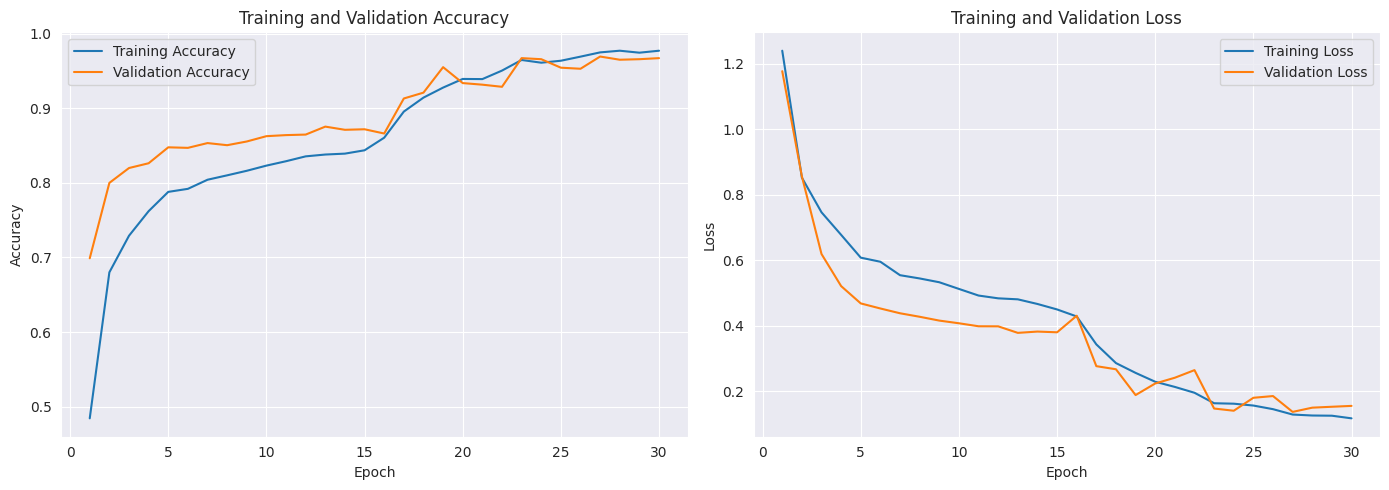

In [41]:
# Menggabungkan riwayat training awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Akurasi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

*Mempersiapkan data testing dengan menormalisasi gambar, lalu memuat dataset testing dari folder. Setelah itu, model dievaluasi menggunakan data testing tersebut, dan hasil akurasi serta loss ditampilkan.*

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Data generator untuk testing ===
test_datagen = ImageDataGenerator(rescale=1./255)

# === Load test dataset ===
test_data = test_datagen.flow_from_directory(
    '/content/brain_tumor/split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 704 images belonging to 4 classes.


In [47]:
# === Evaluasi model pada data test ===
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9638 - loss: 0.1549

Test Accuracy: 97.16%
Test Loss: 0.1291


#### **Confusion Matrix**

*Mengevaluasi akurasi model klasifikasi tumor otak dengan membuat dan menampilkan confusion matrix berdasarkan label asli dan prediksi model terhadap empat kelas: **glioma, meningioma, notumor, dan pituitary**.*

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
Class Indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


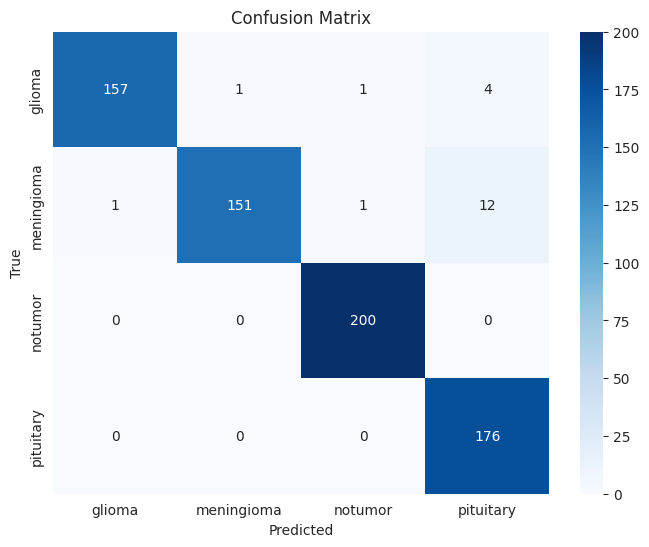

In [51]:
# Daftar kelas sesuai urutan pada folder dataset
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

y_true = test_data.classes

y_pred_probabilities = model.predict(test_data)
y_pred = np.argmax(y_pred_probabilities, axis=1)

class_indices = test_data.class_indices
print("Class Indices:", class_indices)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(class_indices.values()))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### **Classification Report**

*Menghasilkan classification report yang menampilkan metrik evaluasi seperti **precision, recall, dan f1-score** untuk tiap kelas (glioma, meningioma, notumor, pituitary) yang dimana digunakan untuk menilai performa model klasifikasi secara detail.*

In [52]:
# Classification report
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       163
  meningioma       0.99      0.92      0.95       165
     notumor       0.99      1.00      1.00       200
   pituitary       0.92      1.00      0.96       176

    accuracy                           0.97       704
   macro avg       0.97      0.97      0.97       704
weighted avg       0.97      0.97      0.97       704

